# Improving Data Quality
When we're dealing with machine learning, the quality of our outputs is going to be directly proportional to the quality of our data. Not only that the data has meaningful information in it that we can gain insight from, but also that it is in the correct format for our machine learning model. Machine learning is essentially matrix multiplication on a massive scale and as such we need to ensure our models can carry out these calculations by ensuring that we "feed" them useful information.

In this notebook, I'm going to work through an example where I improve the quality of a raw dataset. 

Specifically I'm going to:
* Resolve missing values
* Convert string dates to DateTime format
* Create one-hot encodings for relevant features
* Understand temporal feature conversions

## Install dependencies
The first thing we're going to do is import all of the required dependencies for these tasks.

In [92]:
import subprocess

# Function to run shell commands silently
def run_command_silent(command):
    try:
        subprocess.run(command, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Failed to run command: {command}")

# Run pip install commands silently
run_command_silent("pip install tensorflow")
run_command_silent("pip install pandas")
run_command_silent("pip install numpy")
run_command_silent("pip install datetime")
run_command_silent("pip install matplotlib")
run_command_silent("pip install seaborn")


Start by importing the necessary libraries for this lab.

### Import Libraries
Now that we've installed all of our dependencies, we need to import them into the program.

In [93]:
# Importing necessary tensorflow library and printing the TF version.
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)
import os
import pandas as pd  # First, we'll import Pandas, a data processing and CSV file I/O library
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

TensorFlow version:  2.16.2


### Read Dataset into a Pandas DataFrame

Next, let's read in the dataset just copied from the cloud storage bucket and create a Pandas DataFrame.  We also add a Pandas .head() function to show you the top 5 rows of data in the DataFrame. Head() and Tail() are "best-practice" functions used to investigate datasets.  

In [94]:
df_transport = pd.read_csv('./data/untidy_vehicle_data_toy.csv')
df_transport.head() # Output the first five rows.

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
0,10/1/2018,90000.0,2006,Gasoline,OTHER/UNK,NaN,1.0
1,10/1/2018,NaN,2014,Gasoline,NaN,Yes,1.0
2,NaN,90000.0,NaN,Gasoline,OTHER/UNK,Yes,NaN
3,10/1/2018,90000.0,2017,Gasoline,OTHER/UNK,Yes,1.0
4,10/1/2018,90000.0,<2006,Diesel and Diesel Hybrid,OTHER/UNK,No,55.0


### DataFrame Column Data Types
DataFrames are like spreadsheets in that they contain entries (or records) of "mixed" (heterogenous) data types. Some columns contain integers, some contain float values, some strings, some boolean etc.

CSV files don't contain metadata that would allow us to know what types of data are stored in each column but pandas (one of the libraries that we're using) infers this information for us.

Let's take a look at what sort of data is in our DataFrame

In [95]:
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        497 non-null    object 
 1   Zip Code    497 non-null    float64
 2   Model Year  497 non-null    object 
 3   Fuel        497 non-null    object 
 4   Make        496 non-null    object 
 5   Light_Duty  496 non-null    object 
 6   Vehicles    496 non-null    float64
dtypes: float64(2), object(5)
memory usage: 27.4+ KB


We can see that we have 6 string objects (Denoted by *object* in the output above) and one float object.

We can print out the first and last five rows of each column which will allow us to clearly see these data types and where they are in the DataFrame.

In [96]:
print(df_transport)

          Date  Zip Code Model Year                      Fuel       Make  \
0    10/1/2018   90000.0       2006                  Gasoline  OTHER/UNK   
1    10/1/2018       NaN       2014                  Gasoline        NaN   
2          NaN   90000.0        NaN                  Gasoline  OTHER/UNK   
3    10/1/2018   90000.0       2017                  Gasoline  OTHER/UNK   
4    10/1/2018   90000.0      <2006  Diesel and Diesel Hybrid  OTHER/UNK   
..         ...       ...        ...                       ...        ...   
494  12/3/2018   90002.0       2010                  Gasoline     Type_I   
495  12/4/2018   90002.0       2010                  Gasoline     Type_B   
496  12/5/2018   90002.0       2010                  Gasoline     Type_C   
497  12/6/2018   90002.0       2010                  Gasoline     Type_J   
498  12/7/2018   90002.0       2010                  Gasoline     Type_J   

    Light_Duty  Vehicles  
0          NaN       1.0  
1          Yes       1.0  
2     

### Summary Statistics 
Now that we've got our DataFrame loaded into the notebook, we can use describe() to see a summary of the numerical data in the DataFrame. We need to do this because we're interested in the various statistical measures relating to those values.

In [97]:
df_transport.describe()

,Zip Code,Vehicles
count,497.00000,496.000000
mean,89838.23340,74.512097
std,3633.35609,243.839871
min,9001.00000,1.000000
25%,90001.00000,14.000000
50%,90001.00000,25.000000
75%,90001.00000,56.250000
max,90002.00000,3178.000000


We can learn a little more about the data by using the groupby() function.

In [98]:
df_transport.groupby('Fuel').first() # Get the first entry for each month. 

,Date,Zip Code,Model Year,Make,Light_Duty,Vehicles
Fuel,,,,,,
Battery Electric,10/1/2018,90000.0,<2006,OTHER/UNK,No,4.0
Diesel and Diesel Hybrid,10/1/2018,90000.0,<2006,OTHER/UNK,No,55.0
Flex-Fuel,10/14/2018,90001.0,2007,Type_A,Yes,78.0
Gasoline,10/1/2018,90000.0,2006,OTHER/UNK,Yes,1.0
Hybrid Gasoline,10/24/2018,90001.0,2009,OTHER/UNK,Yes,18.0
Natural Gas,10/25/2018,90001.0,2009,OTHER/UNK,No,2.0
Other,10/8/2018,90000.0,<2006,OTHER/UNK,Yes,6.0
Plug-in Hybrid,11/2/2018,90001.0,2012,OTHER/UNK,Yes,1.0


#### Checking for Missing Values

Now is the time that we need to figure out if the DataFrame has any missing values. We can't send NULL values to an ML model and as such this step is really important. 

*Note: Pandas recognises both empty cells and NaN types as missing values.*

Let's take a look at all the null values (for all features) in the DataFrame.

In [99]:
df_transport.isnull().sum()

Date          2
Zip Code      2
Model Year    2
Fuel          2
Make          3
Light_Duty    3
Vehicles      3
dtype: int64

In the output above, we see a list of the column names with a count of how many missing values there are in the DataFrame.

We can also inspect each column and see if values are missing by using the following:

In [100]:
print (df_transport['Date'].isnull())

0      False
1      False
2       True
3      False
4      False
       ...  
494    False
495    False
496    False
497    False
498    False
Name: Date, Length: 499, dtype: bool


In [101]:
print (df_transport['Make'].isnull())

0      False
1       True
2      False
3      False
4      False
       ...  
494    False
495    False
496    False
497    False
498    False
Name: Make, Length: 499, dtype: bool


In [102]:
print (df_transport['Model Year'].isnull())

0      False
1      False
2       True
3      False
4      False
       ...  
494    False
495    False
496    False
497    False
498    False
Name: Model Year, Length: 499, dtype: bool


### What do we know (or what can we figure out) at this point?

We'll want to create a summary of our data by rows, columns, features, unique values and missing values.

In [103]:
print ("Rows     : " ,df_transport.shape[0])
print ("Columns  : " ,df_transport.shape[1])
print ("\nFeatures : \n" ,df_transport.columns.tolist())
print ("\nUnique values :  \n",df_transport.nunique())
print ("\nMissing values :  ", df_transport.isnull().sum().values.sum())

Rows     :  499
Columns  :  7

Features : 
 ['Date', 'Zip Code', 'Model Year', 'Fuel', 'Make', 'Light_Duty', 'Vehicles']

Unique values :  
 Date          130
Zip Code        4
Model Year     15
Fuel            8
Make           43
Light_Duty      2
Vehicles      151
dtype: int64

Missing values :   17


We'll print out the data again to see where we are (this time the last 5 and not the first 5 because we use `tail()` and not `head()`).

In [104]:
df_transport.tail()

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
494,12/3/2018,90002.0,2010,Gasoline,Type_I,Yes,11.0
495,12/4/2018,90002.0,2010,Gasoline,Type_B,Yes,58.0
496,12/5/2018,90002.0,2010,Gasoline,Type_C,Yes,45.0
497,12/6/2018,90002.0,2010,Gasoline,Type_J,Yes,82.0
498,12/7/2018,90002.0,2010,Gasoline,Type_J,Yes,12.0


### What are the data quality issues at this point?

1. **Missing Values:** Each column has multiple missing values (we have a total of 18 missing values).
2. **Date DataType:** Currently the date is in the form of a string. We would need to convert this string into datetime datatype (dd/mm/YY).
3. **Model Year:** There are years in the "Model Year" column that contain "<2006" and we need to change these to "2006".
4. **Categorical Columns:**  The "Light_Duty" feature (column) is a categorical column ("Yes/No") and we can't feed these into a ML model as it is so we are going to need to deal with these (we will use one-hot encoding for this). 
5. **Temporal Features**:  We will need to deal with the day, month and year (more on this in a bit).

#### Data Quality Issue #1 (Resolving Missing Values):
When we come across missing values in our data we can't always just delete the rows because we may be missing out on important information that could help guide our inference. There are a vast array of methods that we can use to "deal" with missing values but I'm not going to go deep into that in this notebook.

As a simple rule of thumb we can follow the following rules:
**Numeric columns:** We use the "mean" values.
**Categorical columns:** We use the "mode" (most frequent)

We will use the `apply()` function to apply a lambda function to fill every column.

Let's take a look at the stats that we have so far.

In [105]:
df_transport.isnull().sum()

Date          2
Zip Code      2
Model Year    2
Fuel          2
Make          3
Light_Duty    3
Vehicles      3
dtype: int64

Apply the lambda function.

In [106]:
df_transport = df_transport.apply(lambda x:x.fillna(x.value_counts().index[0]))

Re-check the missing values again.

In [107]:
df_transport.isnull().sum()

Date          0
Zip Code      0
Model Year    0
Fuel          0
Make          0
Light_Duty    0
Vehicles      0
dtype: int64

We can see that now there are no missing values in the DataFrame.

#### Data Quality Issue #2 (Convert the Date Feature Column to a Datetime Format):  

The "Date" column is a string and we need to convert the values into data time using the `to_datetime()` function.

In [108]:
df_transport['Date'] =  pd.to_datetime(df_transport['Date'], format='%m/%d/%Y')

Let's take a look at the converted dates.

In [109]:
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        499 non-null    datetime64[ns]
 1   Zip Code    499 non-null    float64       
 2   Model Year  499 non-null    object        
 3   Fuel        499 non-null    object        
 4   Make        499 non-null    object        
 5   Light_Duty  499 non-null    object        
 6   Vehicles    499 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 27.4+ KB


Now we want to split the date into three parts (day, month and year) to create some new columns.

In [110]:
df_transport['year'] = df_transport['Date'].dt.year
df_transport['month'] = df_transport['Date'].dt.month
df_transport['day'] = df_transport['Date'].dt.day
#df['hour'] = df['date'].dt.hour - use this if the date includes hours.
#df['minute'] = df['date'].dt.minute - use this if the date includes minutes.
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        499 non-null    datetime64[ns]
 1   Zip Code    499 non-null    float64       
 2   Model Year  499 non-null    object        
 3   Fuel        499 non-null    object        
 4   Make        499 non-null    object        
 5   Light_Duty  499 non-null    object        
 6   Vehicles    499 non-null    float64       
 7   year        499 non-null    int32         
 8   month       499 non-null    int32         
 9   day         499 non-null    int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(4)
memory usage: 33.3+ KB


What we need to do now is confirm the parsing of the date. 

In [111]:
# Get the first entry for each month.
df_transport.groupby('month').first()

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles,year,day
month,,,,,,,,,
1,2019-01-01,90001.0,2016,Gasoline,Type_G,Yes,18.0,2019,1
2,2019-02-01,90001.0,2017,Gasoline,Type_D,Yes,13.0,2019,1
3,2019-03-01,90001.0,2018,Gasoline,Type_C,Yes,32.0,2019,1
10,2018-10-01,90000.0,2006,Gasoline,OTHER/UNK,Yes,1.0,2018,1
11,2018-11-01,90001.0,2007,Gasoline,Type_M,Yes,15.0,2018,1
12,2018-12-02,90001.0,2015,Gasoline,Type_G,Yes,19.0,2018,2


Looking at the table above, we can see that the date has successfully been parsed. Let's plot the data to inspect it further.

<Figure size 1000x600 with 0 Axes>

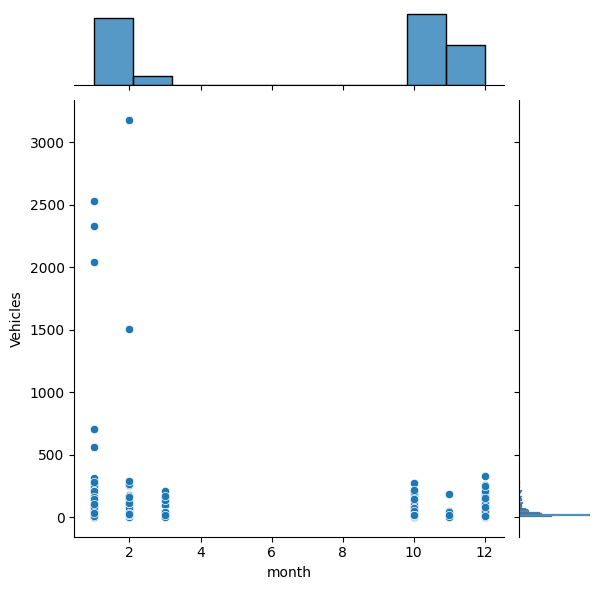

In [112]:
plt.figure(figsize=(10,6))
sns.jointplot(x='month',y='Vehicles',data=df_transport)
#plt.title('Vehicles by Month')

#### Data Quality Issue #3 (Rename a Feature Column and Remove a Value):

If you look at the column names we can see that there are some problems. The first problem is the capitalisations in the titles and the second is the spaces.  

In [113]:
print ("\nFeatures : \n" ,df_transport.columns.tolist())


Features : 
 ['Date', 'Zip Code', 'Model Year', 'Fuel', 'Make', 'Light_Duty', 'Vehicles', 'year', 'month', 'day']


Now let's sort this out by renaming the columns.

In [114]:
df_transport.rename(columns = { 
    'Date': 'date', 
    'Zip Code':'zipcode', 
    'Model Year': 'modelyear', 
    'Fuel': 'fuel', 
    'Make': 'make', 
    'Light_Duty': 'lightduty', 
    'Vehicles': 'vehicles'
    }, inplace = True
) 

Let's make sure that worked.

In [115]:
print ("\nFeatures : \n" ,df_transport.columns.tolist())
df_transport.head()


Features : 
 ['date', 'zipcode', 'modelyear', 'fuel', 'make', 'lightduty', 'vehicles', 'year', 'month', 'day']


,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day
0,2018-10-01,90000.0,2006,Gasoline,OTHER/UNK,Yes,1.0,2018,10,1
1,2018-10-01,90001.0,2014,Gasoline,OTHER/UNK,Yes,1.0,2018,10,1
2,2018-10-01,90000.0,<2006,Gasoline,OTHER/UNK,Yes,13.0,2018,10,1
3,2018-10-01,90000.0,2017,Gasoline,OTHER/UNK,Yes,1.0,2018,10,1
4,2018-10-01,90000.0,<2006,Diesel and Diesel Hybrid,OTHER/UNK,No,55.0,2018,10,1


 **Note:** To avoid the "SettingWithCopyWarning" warning we will now create a copy of the DataFrame. As we create this copy we deal with the "<2006" values from the DataFrame.

In [116]:
df = df_transport.loc[df_transport.modelyear != '<2006'].copy()

Now we confirm that values '<2006' in modelyear have been removed. We do this by doing a value count.

In [117]:
df['modelyear'].value_counts(0)

modelyear
2007    53
2008    45
2006    36
2010    34
2014    31
2015    30
2017    29
2016    29
2013    27
2009    25
2012    25
2011    24
2018    23
2019     5
Name: count, dtype: int64

#### Data Quality Issue #4 (Handling Categorical Columns):

We have a column called "lightduty" in our DataFrame which is a "Yes/No" choice (currently in the form of a string value). We can't use this type of data in a neural network so we are going to convert the "Yes/No" into "0/1" (integer) values. To do this we will use the `apply()` function and use a lambda expression to achieve this transformation.

Before we do that, let's take a look at home many "Yes" and "No" values that we have.

In [118]:
df['lightduty'].value_counts(0)

lightduty
Yes    374
No      42
Name: count, dtype: int64

##### What is a Lambda Function?
Lambda functions are a simple one-line function that is applied to each item in the dataset (we don't use the "def" keyword here to declare the function as lambda functions are anonymous and as such we don't need to name them).

Now let's use the lambda function to change the "Yes" values to 1 and "No" values to 0. We can do this with pandas using the `apply()` function.

In [119]:
df.loc[:,'lightduty'] = df['lightduty'].apply(lambda x: 0 if x=='No' else 1)

Now that's done, let's make sure the DataFrame has the same stats as before.

In [120]:
df['lightduty'].value_counts(0)

lightduty
1    374
0     42
Name: count, dtype: int64

We can also inspect the DataFrame to ensure those values have been changed.

In [121]:
df.head()

,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day
0,2018-10-01,90000.0,2006,Gasoline,OTHER/UNK,1,1.0,2018,10,1
1,2018-10-01,90001.0,2014,Gasoline,OTHER/UNK,1,1.0,2018,10,1
3,2018-10-01,90000.0,2017,Gasoline,OTHER/UNK,1,1.0,2018,10,1
16,2018-10-09,90001.0,2006,Diesel and Diesel Hybrid,Type_C,0,16.0,2018,10,9
17,2018-10-10,90001.0,2006,Diesel and Diesel Hybrid,OTHER/UNK,0,23.0,2018,10,10


#### One-Hot Encoding Categorical Feature Columns
When it comes to categorical data there are a few options on how tod eal with them. One method could be to give each class a value i.e. Yes=1 and No=2. The problem with this approach is that our ML model may think that higher values are more important i.e. in this example "No" is more important than "Yes" because it is a 2 while "Yes" is a 1.

To avoid this problem we can use a technique called one-hot encoding which essentially creates new columns for each of the classes i.e. a new column for "No" and a new column for "Yes". To represent a Yes in this example we would place a 0 in the "No" column and a 1 in the "Yes" column and the same vice versa. 

There is a function in pandas called `get_dummies()` which we can use to convert categorical variables into dummy/indicator variables.

In [122]:
data_dummy = pd.get_dummies(df[['zipcode','modelyear', 'fuel', 'make']], drop_first=True)

Let's take a look at this `data_dummy` DataFrame that we just made:

In [123]:
data_dummy.head()

,zipcode,modelyear_2007,modelyear_2008,modelyear_2009,modelyear_2010,modelyear_2011,modelyear_2012,modelyear_2013,modelyear_2014,modelyear_2015,...,make_Type_P,make_Type_Q,make_Type_R,make_Type_S,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y
0,90000.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,90001.0,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,90000.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16,90001.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17,90001.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now we need to merge (concatenate) original DataFrame with newly created `data_dummy` DataFrame.

In [124]:
df = pd.concat([df,data_dummy], axis=1)

Now let's make sure that the `df` DataFrame has been concatenated with the `data_dummy` DataFrame.

In [125]:
df.head()

,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day,...,make_Type_P,make_Type_Q,make_Type_R,make_Type_S,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y
0,2018-10-01,90000.0,2006,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,False,False,False,False,False,False,False,False,False,False
1,2018-10-01,90001.0,2014,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,False,False,False,False,False,False,False,False,False,False
3,2018-10-01,90000.0,2017,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,False,False,False,False,False,False,False,False,False,False
16,2018-10-09,90001.0,2006,Diesel and Diesel Hybrid,Type_C,0,16.0,2018,10,9,...,False,False,False,False,False,False,False,False,False,False
17,2018-10-10,90001.0,2006,Diesel and Diesel Hybrid,OTHER/UNK,0,23.0,2018,10,10,...,False,False,False,False,False,False,False,False,False,False


Once we have added these one-hot encoded columns to the DataFrame we can now remove the originals.

In [126]:
df = df.drop(['date','zipcode','modelyear', 'fuel', 'make'], axis=1)

Now we confirm that those changes have successfully been made.

In [127]:
df.head()

,lightduty,vehicles,year,month,day,modelyear_2007,modelyear_2008,modelyear_2009,modelyear_2010,modelyear_2011,...,make_Type_P,make_Type_Q,make_Type_R,make_Type_S,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y
0,1,1.0,2018,10,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,1.0,2018,10,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,1.0,2018,10,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16,0,16.0,2018,10,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17,0,23.0,2018,10,10,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Data Quality Issue #5 (Temporal Feature Columns):
As it stands, we have day, month and year features. What we want to do now is convert the month and day columns into meaningful representations.

This is something that we call feature engineering where we take 1 or more features and create new features that would (ideally) be more meaningful to our model than the original features would be in their current state.

Before we do this, let's get an idea of what our data looks like (for the "day" and "month" value).

In [128]:
print ('Unique values of month:', df.month.unique())
print ('Unique values of day:', df.day.unique())
print ('Unique values of year:', df.year.unique())

Unique values of month: [10 11 12  1  2  3]
Unique values of day: [ 1  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
  2  3  4  5  6  7  8]
Unique values of year: [2018 2019]


We're now going to map each temporal value into a circle so that the lowest value is right next to the largest value (like a clock).

In [129]:
df['day_sin'] = np.sin(df.day*(2.*np.pi/31))
df['day_cos'] = np.cos(df.day*(2.*np.pi/31))
df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))

Now we need to drop the original "day" and "month" columns.

In [130]:
df = df.drop(['month','day','year'], axis=1)

Let's take a look to ensure all this has happened.

In [131]:
df.tail(4)

,lightduty,vehicles,modelyear_2007,modelyear_2008,modelyear_2009,modelyear_2010,modelyear_2011,modelyear_2012,modelyear_2013,modelyear_2014,...,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y,day_sin,day_cos,month_sin,month_cos
495,1,58.0,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,0.724793,0.688967,-0.5,0.866025
496,1,45.0,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,0.848644,0.528964,-0.5,0.866025
497,1,82.0,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,0.937752,0.347305,-0.5,0.866025
498,1,12.0,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,0.988468,0.151428,-0.5,0.866025
